# General instructions for all labs

1. To turn in:
 - this python notebook, filled out (2 pts)
 - a *standalone* PDF report that contains all the plots, and the answers to all the discussion questions (2 pts)

2. Use of ChatGPT / CoPilot / etc:
   - Allowed, but you own everything that is generated
   - This means that any part of the solution can be asked in the quiz. It can be as detailed as "What was the batch size you used in training" or specific as "what exactly does masking do in this case?" Any discussion question is also game for a quiz question.
   - If I find AI usage to be excessive. I can individually drag any of you in for a 1-1 meeting, in which I grill you on your code. If it looks like irresponsible copy/pasting, without proper understanding, I reserve the right to drastically lower your grade, or even submit cases to GGAC for ethical review.
  
3. Use of peer collaboration:
   - In general not allowed. (Discussion / comparing answers is ok, but work on actual coding independently.)
   - Exceptions can be made if you all wrote your own training script, but 1. it takes forever to train or 2. you don't have great compute resources. Then you can share a trained model amongst yourself *and declare it on your pdf*. However, the code for training *still must be written by yourself*
     




# Lab 3: Scalable Retrieval with Project Gutenberg

Modern AI systems don’t just generate answers — they rely on **retrieval** to find the right context before generation. Whether you’re building a search engine, a recommendation system, or a Retrieval-Augmented Generation (RAG) pipeline, the quality and speed of retrieval often determine how useful the final system will be.

In this lab, you’ll explore the core ideas of **scalable** retrieval using Project Gutenberg texts. Books are long, hierarchical, and varied — which makes them an excellent testbed for learning how to index, search, and evaluate retrieval aton, or just keep it high-level so the reranker is an assignment step?
tudents can *see* the difference between the two structures?
letions spelled out as mini-exercises)?


## 📚 The Project Gutenberg Corpus

For this lab, we will be working with texts from **Project Gutenberg**, a large collection of public-domain books. Project Gutenberg has been digitizing and distributing literary works since 1971, making it one of the oldest and largest open digital libraries. The collection spans over **70,000 works**, ranging from classic literature to historical documents.

Because the raw Project Gutenberg site can be tricky to scrape (inconsistent file formats, encodings, and compression), we’ll use a cleaned dataset hosted on Kaggle:

👉 [Project Gutenberg – Over 70,000 Books (Kaggle Dataset)](https://www.kaggle.com/datasets/jasonheesanglee/gutenberg-over-70000)

This version provides a consolidated, reproducible collection of the corpus, which avoids many of the Unicode and file format errors students encounter when downloading directly from gutenberg.org.

We’ll use this dataset as our **source corpus** for chunking, embedding, and retrieval experiments.



## Part 1: Download and Inspect the Data

1. **Download the dataset**

   * Use the Kaggle link above: [Project Gutenberg – Over 70,000 Books](https://www.kaggle.com/datasets/jasonheesanglee/gutenberg-over-70000).
   * Unzip the dataset into a directory on your computer. You should see:

     * Many book files in `.pkl` format (each file contains the text of a book).
     * A metadata file called `gutenberg_over_70000_metadata.csv`.

2. **Inspect the book files and metadata**

   * Scripts are provided to walk through the directory and preview the contents of `.pkl` files (e.g., first 100 characters or tokens).
   * The metadata file contains details such as book ID, title, and author.
   * Run them and look around a bit.

3. **Load the data**
   * You will extend these inspection scripts to combine the book text and metadata into a single data structure:

     * **Key:** book number (ID)
     * **Value:** dictionary with both the text and metadata details.
    **You may not want to load all the data at once, as that is very memory intensive. Just have a natural break point at, say, 1000 books, which you can remove later once we decide to modify this function to be more efficient.**



In [ ]:
%pip -q install sentence-transformers faiss-cpu hnswlib

In [1]:
# --- Cell 0: imports & basic setup ---
import os
import re
import gc
import sys
import glob
import json
import math
import time
import pickle
import pathlib
from pathlib import Path
from typing import Dict, Any, Iterable, Tuple, List, Optional

import numpy as np
import pandas as pd

# If FAISS is available, we'll use it. Otherwise we fall back to a numpy search.
try:
    import faiss  # pip install faiss-cpu
    FAISS_AVAILABLE = True
except Exception:
    FAISS_AVAILABLE = False

# Embeddings
from sentence_transformers import SentenceTransformer

# Pretty progress
from tqdm.auto import tqdm

# Paths (relative to the notebook file)
ROOT = Path(".").resolve()
ARCHIVE_DIR = ROOT / "archive"
METADATA_CSV = ROOT / "gutenberg_over_70000_metadata.csv"
OUT_DIR = ROOT / "lab3_outputs"
OUT_DIR.mkdir(exist_ok=True)

print("ROOT:", ROOT)
print("ARCHIVE_DIR exists:", ARCHIVE_DIR.exists())
print("OUT_DIR:", OUT_DIR)
print("FAISS available:", FAISS_AVAILABLE)



ROOT: C:\Users\katya\OneDrive\Desktop\sbu stuff\important documents\sbu everything\1st sem subject\dfs\Lab 3
ARCHIVE_DIR exists: True
OUT_DIR: C:\Users\katya\OneDrive\Desktop\sbu stuff\important documents\sbu everything\1st sem subject\dfs\Lab 3\lab3_outputs
FAISS available: True


In [2]:
import os
import pickle
import pandas as pd
from IPython.display import display

def load_metadata(root_dir):
    filepath = os.path.join(root_dir, 'gutenberg_over_70000_metadata.csv')
    try:
        df = pd.read_csv(filepath)
        
        print("\nFilepath:", filepath)
        display(df.head(10))          # Show first 10 rows
        print("Total rows:", len(df))
    
    except Exception as e:
        print(f"Error opening {filepath}: {e}")
    
def preview_pkl_files(root_dir):
    """
    Traverse root_dir and subdirectories, open .pkl files, 
    and print a preview of the first 100 characters or words.
    """
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".pkl"):
                filepath = os.path.join(subdir, file)
                try:
                    with open(filepath, "rb") as f:
                        data = pickle.load(f)
                    
                    print('\n',filepath, data[:10],len(data))
                
                except Exception as e:
                    print(f"Error opening {filepath}: {e}")

# Example usage

load_metadata('archive')
#preview_pkl_files("archive")



Filepath: archive\gutenberg_over_70000_metadata.csv


Unnamed: 0  Book Num                                         Book Title  \
0           0         1  The Declaration of Independence of the United ...   
1           1         2  The United States Bill of Rights by United States   
2           2         3  John F. Kennedy's Inaugural Address by John F....   
3           3         4    Lincoln's Gettysburg Address by Abraham Lincoln   
4           4         5    The United States Constitution by United States   
5           5         6  Give Me Liberty or Give Me Death by Patrick Henry   
6           6         7                              The Mayflower Compact   
7           7         8  Abraham Lincoln's Second Inaugural Address by ...   
8           8         9  Abraham Lincoln's First Inaugural Address by A...   
9           9        10                The King James Version of the Bible   

  Language                              Author Original Publication Date  \
0  English                   Jefferson, Thomas                         -   
1  English                       United States                         -   
2  English  Kennedy, John F. (John Fitzgerald)                         -   
3  English                    Lincoln, Abraham                         -   
4  English                       United States                         -   
5  English                      Henry, Patrick                         -   
6  English                         Unavailable                         -   
7  English                    Lincoln, Abraham                         -   
8  English                    Lincoln, Abraham                         -   
9  English                         Unavailable                         -   

  Published Date  
0    Dec 1, 1971  
1    Dec 1, 1972  
2    Nov 1, 1973  
3    Nov 1, 1973  
4    Dec 1, 1975  
5    Dec 1, 1976  
6    Dec 1, 1977  
7    Dec 1, 1978  
8    Dec 1, 1979  
9    Aug 1, 1989

Total rows: 71915




## 📖 From Text to Embeddings

Note that actually loading the raw text of all the books is extremely cumbersome, and also not that useful for retrieval. Instead, for retrieval systems, we don’t search directly over words — we search in **embedding space**, where each passage of text is represented as a dense vector.

Why do we need **chunking**?

* Embedding models have a **fixed input size** (typically 512–1024 tokens). A whole book is far too long to fit.
* Even if a model could process the entire book, a single embedding would dilute meaning — specific details would get lost.
* By splitting the book into smaller, overlapping passages (e.g. 500 words with 50 words overlap), we keep each chunk semantically coherent and within the model’s capacity.

Why do we need **aggregation**?

* If we only keep passage-level embeddings, retrieval becomes more expensive (millions of vectors).
* Sometimes we want a **compact representation** of the entire book (for catalog search, or as a coarse filter before drilling down).
* Aggregating embeddings — for example by **averaging** all chunk embeddings — provides this compact representation while still reflecting the book’s overall content.
* Averaging is a simple and widely used method: it balances the contributions of all chunks without blowing up dimensionality. Other methods (max pooling, weighted averaging, multi-vector representations) exist, but averaging is the most practical starting point.

---
--

Since entire books are far too long to embed directly, we need to:

1. **Chunk** the book into smaller passages (e.g. \~500 words each, with overlap).
2. **Embed** each passage using a pretrained model.
3. **Aggregate** the embeddings into a single book-level vector (e.g. by averaging).

Computing embeddings for all chunks can be expensive. To make this feasible, we will **subsample** by taking only the first *N* chunks (e.g. $N=1$) per book. This reduces memory and runtime while still giving a representative eme students?



### Your Task

* First, look over the two functions offered to you below. You can use them, modify them, or rewrite your own functions. If you use these ones, please fill out the prompts in the comments, as you could be asked about it later.
* Next, modify your loading function from above to load the embedding computed from the text, rather than the entire text itself. You should notice that memory does not grow nearly as large.

Once it is all loaded, you can save it in a pkl file, to be easily loaded in the future.

This step can take a while. You may not want to do it last minute.


In [3]:
# --- helper functions modified a bit(chunking + embedding with aggregation & subsampling)

from sentence_transformers import SentenceTransformer
import numpy as np

# Reuse a single model instance across the notebook
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def chunk_text(text: str, chunk_size: int = 500, overlap: int = 50, max_num_chunks: int | None = None) -> list[str]:
    """
    Splits a long string into overlapping word windows.

    INPUT:
      - text: the full book text as a string
      - chunk_size: number of words per chunk (window size)
      - overlap: number of words to overlap between consecutive chunks
      - max_num_chunks: optional hard cap on number of chunks (subsampling)

    OUTPUT:
      - list of string chunks, each ~chunk_size words (except possibly last)

    WHY:
      - Keeps each piece semantically coherent and within the model’s context limit
      - Overlap preserves continuity across chunk boundaries for retrieval
    """
    words = text.split()
    chunks = []
    start = 0
    while start < len(words):
        end = min(start + chunk_size, len(words))
        chunk = " ".join(words[start:end]).strip()
        if chunk:
            chunks.append(chunk)
        if max_num_chunks is not None and len(chunks) >= max_num_chunks:
            break
        if end == len(words):
            break
        start = end - overlap if overlap > 0 else end
    return chunks

def embed_book(
    text: str,
    chunk_size: int = 500,
    overlap: int = 50,
    aggregate: str = "mean",
    max_num_chunks: int | None = 10,
    normalize: bool = True,
) -> dict:
    """
    Converts a book's text into:
      - per-chunk embeddings (subsampled to first `max_num_chunks`)
      - a single book-level vector (by aggregation)

    INPUT:
      - text: full book text
      - chunk_size, overlap: chunking parameters
      - aggregate: how to aggregate chunks into one vector; options:
          "mean" (default), "max", or None (skip aggregation)
      - max_num_chunks: take only the first N chunks for speed/memory (subsampling)
      - normalize: L2-normalize embeddings (good for cosine similarity retrieval)

    OUTPUT (dict):
      {
        "chunks": [str, ...],                  # text chunks (subsampled)
        "chunk_embs": np.ndarray [C, D],       # per-chunk embeddings
        "book_vec": np.ndarray [D] or None,    # aggregated embedding
      }
    """
    chunks = chunk_text(text, chunk_size=chunk_size, overlap=overlap, max_num_chunks=max_num_chunks)
    if len(chunks) == 0:
        return {"chunks": [], "chunk_embs": np.zeros((0, 384), dtype="float32"), "book_vec": None}

    # encode
    chunk_embs = model.encode(
        chunks,
        convert_to_numpy=True,
        normalize_embeddings=normalize
    ).astype("float32")

    # aggregate
    book_vec = None
    if aggregate is None:
        book_vec = None
    elif aggregate == "mean":
        v = chunk_embs.mean(axis=0)
        if normalize:
            v = v / (np.linalg.norm(v) + 1e-12)
        book_vec = v.astype("float32")
    elif aggregate == "max":
        v = chunk_embs.max(axis=0)
        if normalize:
            v = v / (np.linalg.norm(v) + 1e-12)
        book_vec = v.astype("float32")
    else:
        raise ValueError(f"Unknown aggregate: {aggregate}")

    return {"chunks": chunks, "chunk_embs": chunk_embs, "book_vec": book_vec}



In [4]:
# --- parse .pkl text + parse IDs from filenames ---

import re
import pickle
from pathlib import Path
from typing import Any, Optional, Tuple

CANDIDATE_TEXT_KEYS = [
    "text","content","body","book_text","clean_text","full_text",
    "raw","raw_text","data","doc","document"
]
CANDIDATE_LIST_KEYS = ["chunks","chapters","paragraphs","sentences","pages","sections"]

def safe_load_pickle(p: Path) -> Any:
    with open(p, "rb") as f:
        return pickle.load(f)

def extract_text_from_any(obj: Any) -> Optional[str]:
    # direct string
    if isinstance(obj, str):
        return obj

    # dict schema
    if isinstance(obj, dict):
        for k in CANDIDATE_TEXT_KEYS:
            v = obj.get(k)
            if isinstance(v, str) and v.strip():
                return v
        for k in CANDIDATE_LIST_KEYS:
            v = obj.get(k)
            if isinstance(v, (list, tuple)):
                parts = []
                for it in v:
                    if isinstance(it, str):
                        parts.append(it)
                    elif isinstance(it, dict):
                        for tk in CANDIDATE_TEXT_KEYS:
                            tv = it.get(tk)
                            if isinstance(tv, str) and tv.strip():
                                parts.append(tv)
                                break
                if parts:
                    return "\n\n".join(parts)

    # list/tuple schema
    if isinstance(obj, (list, tuple)):
        parts = []
        for it in obj:
            if isinstance(it, str):
                parts.append(it)
            elif isinstance(it, dict):
                for tk in CANDIDATE_TEXT_KEYS:
                    tv = it.get(tk) if isinstance(it, dict) else None
                    if isinstance(tv, str) and tv.strip():
                        parts.append(tv)
                        break
        if parts:
            return "\n\n".join(parts)

    return None

def parse_book_num_from_filename(p: Path) -> Optional[int]:
    """
    Expects '12345_<name>.pkl' as your folders show.
    Returns int(12345) or None if not found.
    """
    m = re.match(r"^(\d+)_", p.stem)
    return int(m.group(1)) if m else None


In [5]:
import os

cwd = os.getcwd()
print("Current working directory:", cwd)


Current working directory: C:\Users\katya\OneDrive\Desktop\sbu stuff\important documents\sbu everything\1st sem subject\dfs\Lab 3


In [6]:
# --- load metadata into a fast lookup dict by Book Num ---

import pandas as pd
METADATA_CSV = Path("archive/gutenberg_over_70000_metadata.csv")

if METADATA_CSV.exists():
    meta_df = pd.read_csv(METADATA_CSV)
    # Your CSV shows "Book Num", "Book Title", "Author", etc.
    # Make a lookup: {Book Num -> row dict}
    if "Book Num" not in meta_df.columns:
        raise ValueError("Expected 'Book Num' column in metadata.")
    meta_df["Book Num"] = pd.to_numeric(meta_df["Book Num"], errors="coerce").astype("Int64")
    metadata_by_id = {
        int(row["Book Num"]): {
            "Book Title": row.get("Book Title"),
            "Author": row.get("Author"),
            "Language": row.get("Language"),
            "Original Publication Date": row.get("Original Publication Date"),
            "Published Date": row.get("Published Date"),
        }
        for _, row in meta_df.iterrows() if not pd.isna(row["Book Num"])
    }
    print("Metadata loaded for", len(metadata_by_id), "Book IDs")
else:
    metadata_by_id = {}
    print("WARNING: metadata CSV not found:", METADATA_CSV)


Metadata loaded for 71915 Book IDs


In [ ]:
# --- Cell D: build {book_id: {...text/metadata/embeddings...}} with subsampling ---

from pathlib import Path
from tqdm.auto import tqdm

# Controls for Part 1
MAX_BOOKS = 1000              # natural breakpoint to manage memory/time
CHUNK_SIZE = 500
OVERLAP = 50
MAX_CHUNKS_PER_BOOK = 10      # subsample: take first N chunks per book
AGGREGATE = "mean"            # "mean" or "max" or None

def iter_all_pickles(archive_root: Path) -> list[Path]:
    # discover pkl files in subranges like 1-500, 501-750, ...
    return sorted(archive_root.rglob("*_*.pkl"))

all_pkl_paths = iter_all_pickles(ARCHIVE_DIR)
print(f"Found {len(all_pkl_paths):,} .pkl files under {ARCHIVE_DIR}")

books: dict[int, dict] = {}
skipped = 0

for p in tqdm(all_pkl_paths, total=len(all_pkl_paths), desc="Processing books"):
    if len(books) >= MAX_BOOKS:
        break

    try:
        book_id = parse_book_num_from_filename(p)
        if book_id is None:
            skipped += 1
            continue

        obj = safe_load_pickle(p)
        text = extract_text_from_any(obj)
        if not text or len(text.strip()) < 50:
            skipped += 1
            continue

        emb_pack = embed_book(
            text,
            chunk_size=CHUNK_SIZE,
            overlap=OVERLAP,
            aggregate=AGGREGATE,
            max_num_chunks=MAX_CHUNKS_PER_BOOK,
            normalize=True
        )

        # assemble record
        rec = {
            "book_id": book_id,
            "source_path": str(p),
            "n_chunks": len(emb_pack["chunks"]),
            "chunk_size": CHUNK_SIZE,
            "overlap": OVERLAP,
            "aggregate": AGGREGATE,
            "chunk_texts": emb_pack["chunks"],            # keep small list (only first N chunks)
            "chunk_embs": emb_pack["chunk_embs"],         # shape [C, D]
            "book_vec": emb_pack["book_vec"],             # shape [D] or None
            "meta": metadata_by_id.get(book_id, {}),      # attach metadata row if available
        }

        books[book_id] = rec

    except Exception as e:
        skipped += 1

print(f"Collected {len(books)} books; skipped {skipped}.")
# Quick peek
some_id = next(iter(books.keys())) if books else None
if some_id is not None:
    print("Example ID:", some_id)
    print("Title:", books[some_id]["meta"].get("Book Title"))
    print("Chunks:", books[some_id]["n_chunks"])
    print("Chunk embs shape:", books[some_id]["chunk_embs"].shape)
    print("Book vec shape:", None if books[some_id]["book_vec"] is None else books[some_id]["book_vec"].shape)


In [3]:
# --- Resume from previous run ---
from pathlib import Path
from tqdm.auto import tqdm
import pickle
import numpy as np
import gc

# Load existing progress (the books you already embedded)
SAVE_PATH = OUT_DIR / "books_embedded_1000_max10chunks.pkl"
if SAVE_PATH.exists():
    with open(SAVE_PATH, "rb") as f:
        books = pickle.load(f)
    already_done = set(books.keys())
    print(f"Loaded previous progress: {len(already_done)} books already processed.")
else:
    books = {}
    already_done = set()
    print("No previous progress found — starting fresh.")

# Now raise the limit or disable it completely
MAX_BOOKS = None   # None = process all remaining books
SKIP_EXISTING = True

all_pkl_paths = iter_all_pickles(ARCHIVE_DIR)
print(f"Found {len(all_pkl_paths):,} .pkl files")

processed = len(books)
skipped = 0

for p in tqdm(all_pkl_paths, total=len(all_pkl_paths), desc="Processing books"):
    book_id = parse_book_num_from_filename(p)
    if book_id is None:
        continue

    if SKIP_EXISTING and book_id in already_done:
        continue  # skip books you already did

    try:
        obj = safe_load_pickle(p)
        text = extract_text_from_any(obj)
        if not text or len(text.strip()) < 50:
            skipped += 1
            continue

        emb_pack = embed_book(
            text,
            chunk_size=CHUNK_SIZE,
            overlap=OVERLAP,
            aggregate=AGGREGATE,
            max_num_chunks=MAX_CHUNKS_PER_BOOK,
            normalize=True
        )

        rec = {
            "book_id": book_id,
            "source_path": str(p),
            "n_chunks": len(emb_pack["chunks"]),
            "chunk_size": CHUNK_SIZE,
            "overlap": OVERLAP,
            "aggregate": AGGREGATE,
            "chunk_texts": emb_pack["chunks"],
            "chunk_embs": emb_pack["chunk_embs"],
            "book_vec": emb_pack["book_vec"],
            "meta": metadata_by_id.get(book_id, {}),
        }

        books[book_id] = rec
        processed += 1

        if processed % 250 == 0:  # save every 250 to be safe
            tmp_path = OUT_DIR / f"books_embedded_partial_{processed}.pkl"
            with open(tmp_path, "wb") as f:
                pickle.dump(books, f, protocol=pickle.HIGHEST_PROTOCOL)
            print(f"Checkpoint saved at {tmp_path}")
            gc.collect()

    except Exception as e:
        skipped += 1

print(f"Resumed run complete. Total books: {len(books)}; Skipped: {skipped}")

# Save final merged output
FINAL_PATH = OUT_DIR / f"books_embedded_full_{len(books)}_max{MAX_CHUNKS_PER_BOOK}chunks.pkl"
with open(FINAL_PATH, "wb") as f:
    pickle.dump(books, f, protocol=pickle.HIGHEST_PROTOCOL)
print("All progress saved to:", FINAL_PATH)


NameError: name 'OUT_DIR' is not defined

## Part 1 – Step 1: Build a Flat k-NN Graph

1. **Pairwise Distances**

   * In your notebook, write out the underlying equations for this computation.
   * Comment on the computational and memory complexity of this approach (it is $O(m^2)$ in both time and space, where $m$ is the number of books).
   * Make sure you understand the math — don’t just memorize it. I may ask you to reproduce it.

2. **Visualization with PCA**

   * Use PCA to reduce the embeddings to 2D, and plot the books in this space.
   * Instead of labeling points with IDs, annotate them with their book titles from the metadata. For example:

     ```python
     plt.text(embedding_2d[i, 0], embedding_2d[i, 1], book_embs[label]['metadata']['Book Title'], fontsize=6, alpha=0.7)
     ```
   * Comment on the geometry and clustering of these visual embeddings. Do they make sense?

3. **Nearest Neighbor Graph**

   * Create a nearest neighbor graph using `networkx`.
   * Each node corresponds to a book embedding.
   * You may connect nodes in one of two ways:

     * **Fixed degree (k-NN):** Connect each node to its $d$ closest neighbors, where $d$ is a hyperparameter (e.g. 5, 10, 20).
     * **Distance threshold:** Connect each node to any other node whose distance is less than a threshold $\varepsilon$, for example the 15th percentile of all pairwise distances.
   * Instead of plotting the raw graph with all its edges (which quickly becomes unreadable), visualize the graph structure using its adjacency matrix.

4. **Discussion**

   * Comment on the pros and cons of constructing an NN graph in each of the two ways.
   * How sensitive is the graph structure to the choice of $d$ or $\varepsilon$?
   * Compare how graph connectivity changes with the hyperparameter (clusters vs. isolated nodes).
 


In [7]:
# --- Part 1 Step 1 / Cell 1: collect book-level embeddings & titles ---

import pickle
import numpy as np
file_path = Path("lab3_outputs/books_embedded_full_70333_max10chunks.pkl")
# If you already have `books` in memory from earlier cells, leave this as-is. Otherwise, uncomment and set the path to your saved file (from Part 1).
with open(file_path, "rb") as f:
    books = pickle.load(f)

# Build matrix X [n_books, d] and parallel lists of ids / titles
book_ids, titles, X = [], [], []
for bid, rec in books.items():
    vec = rec.get("book_vec", None)
    if vec is None:
        continue
    # ensure float32 and normalized (cosine-friendly)
    v = np.asarray(vec, dtype="float32")
    nrm = np.linalg.norm(v) + 1e-12
    v = v / nrm
    X.append(v)
    book_ids.append(bid)
    titles.append(rec.get("meta", {}).get("Book Title", f"Book {bid}"))

X = np.vstack(X).astype("float32")
n, d = X.shape
print(f"Collected {n} book embeddings with dim {d}. Example title:", titles[0] if n > 0 else "N/A")


Collected 70333 book embeddings with dim 384. Example title: The Complete Works of William Shakespeare by William Shakespeare


Pairwise distances and flat k-NN graph — math and complexity

Cosine similarity between two books i and j with normalized vectors xᵢ, xⱼ ∈ ℝᵈ is given by:

  sᵢⱼ = xᵢᵀ xⱼ, with ‖xᵢ‖₂ = ‖xⱼ‖₂ = 1

Cosine distance (which we use to build the graph) is:

  dᵢⱼ = 1 − sᵢⱼ = 1 − xᵢᵀ xⱼ

If you prefer Euclidean distance, for normalized vectors we have:

  ‖xᵢ − xⱼ‖₂² = 2(1 − xᵢᵀ xⱼ) = 2 dᵢⱼ

We compute all pairwise distances to form a flat k-nearest-neighbor (k-NN) graph.
Let n be the number of books.

Time complexity: Computing all pairwise similarities or distances requires O(n² d) operations (which can be implemented efficiently as one large matrix product, X Xᵀ).

Space complexity: Storing the full n × n distance matrix requires O(n²) memory.

For large n, this becomes computationally and memory intensive, so in practice approximate nearest neighbor (ANN) methods or block/streaming approaches are often used to make it feasible.


In [8]:
# --- Part 1 Step 1: compute pairwise cosine distance matrix ---

import numpy as np

def pairwise_cosine_distance(X: np.ndarray) -> np.ndarray:
    """
    X: [n, d], assumed L2-normalized rows.
    Returns D: [n, n] where D[i,j] = 1 - dot(X[i], X[j]).
    """
    S = X @ X.T                       # cosine similarity
    np.clip(S, -1.0, 1.0, out=S)      # numerical safety
    D = 1.0 - S
    np.fill_diagonal(D, 0.0)
    return D

D = pairwise_cosine_distance(X)
print("Distance matrix shape:", D.shape, "min/max:", float(D.min()), float(D.max()))
print(f"Memory for D ~ {D.size * D.itemsize / 1e6:.1f} MB")


Distance matrix shape: (70333, 70333) min/max: 0.0 1.2628852128982544
Memory for D ~ 19786.9 MB


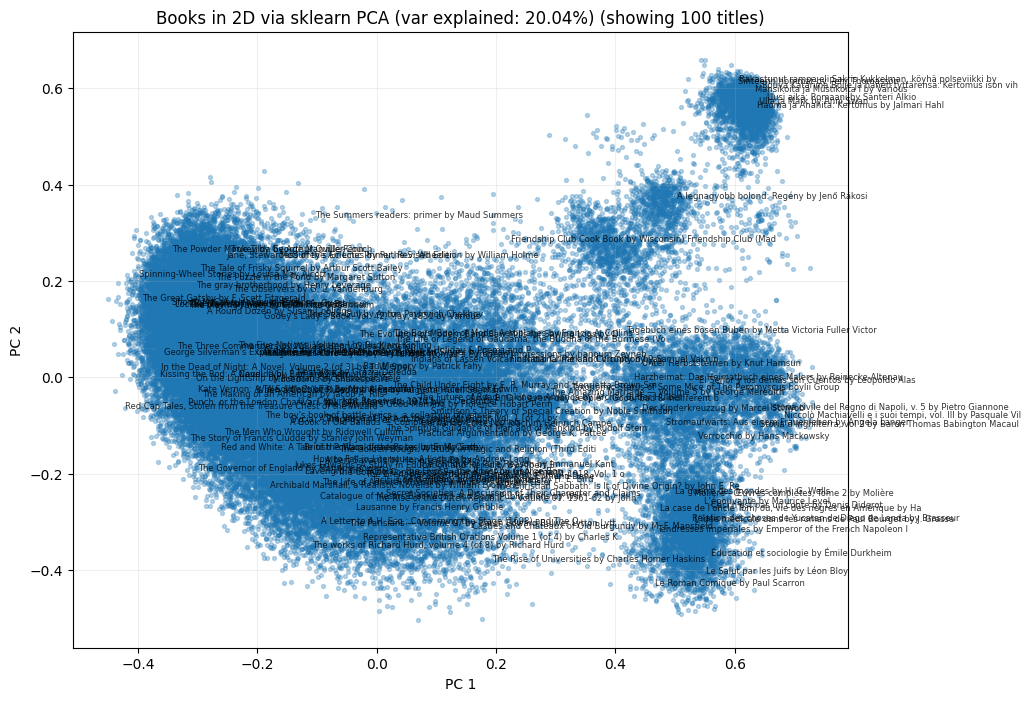

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Try sklearn PCA, fall back to numpy SVD if not available
try:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)
    explained = pca.explained_variance_ratio_.sum()
    method = f"sklearn PCA (var explained: {explained:.2%})"
except Exception:
    # Center and do SVD for 2D
    Xc = X - X.mean(axis=0, keepdims=True)
    U, Svals, Vt = np.linalg.svd(Xc, full_matrices=False)
    X2 = U[:, :2] * Svals[:2]
    method = "numpy SVD (2D)"

# Randomly select 100 books to label
rng = np.random.default_rng(42)
label_idx = rng.choice(len(titles), size=min(119, len(titles)), replace=False)

plt.figure(figsize=(10, 8))
plt.scatter(X2[:, 0], X2[:, 1], s=8, alpha=0.3)

# Label only the selected 100 books
for i in label_idx:
    plt.text(X2[i, 0], X2[i, 1], str(titles[i])[:60], fontsize=6, alpha=0.8)

plt.title(f"Books in 2D via {method} (showing 100 titles)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(alpha=0.2)
plt.show()




n=70333, d=384


C:\Users\katya\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26827 (\N{CJK UNIFIED IDEOGRAPH-68CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\katya\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32147 (\N{CJK UNIFIED IDEOGRAPH-7D93}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


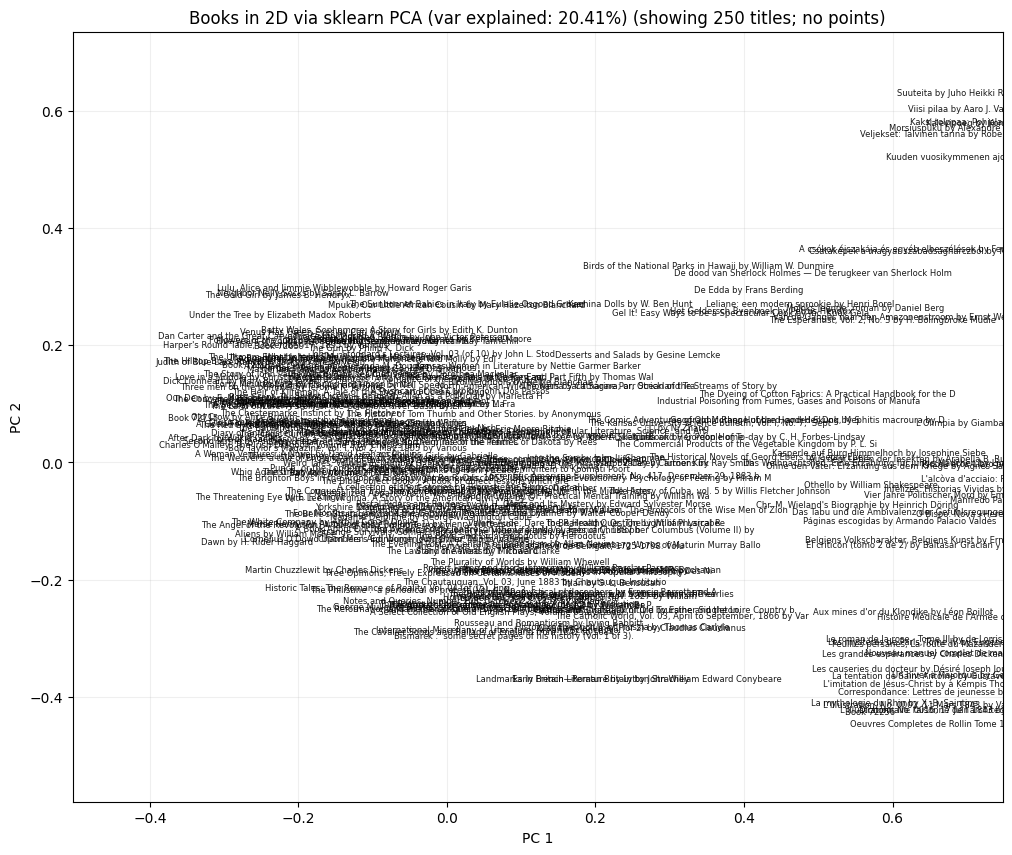

[k-NN sparse] nodes=70333, undirected edges≈119061, components=15518, largest=44000, median=1


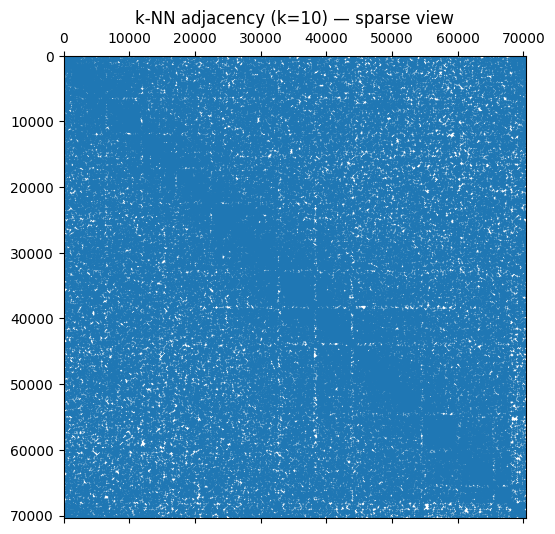

In [10]:
# ============================
# PCA (labels only) + streaming k-NN (memory-safe)
# ============================

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.csgraph import connected_components

# -------- 0) Assume you already have X (n,d) and titles --------
# Ensure float32 + L2-normalize once (cosine-friendly)
X = X.astype("float32", copy=False)
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
n, d = X.shape
print(f"n={n}, d={d}")

# -------- 1) PCA to 2D for visualization (fit on a subset to keep it quick) --------
SUB_PCA = min(10000, n)      # fit/plot coordinates for up to 10k books
rng = np.random.default_rng(42)
idx_pca = rng.choice(n, size=SUB_PCA, replace=False) if n > SUB_PCA else np.arange(n)
Xp = X[idx_pca]

try:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(Xp)
    explained = pca.explained_variance_ratio_.sum()
    method = f"sklearn PCA (var explained: {explained:.2%})"
except Exception:
    Xc = Xp - Xp.mean(axis=0, keepdims=True)
    U, Svals, Vt = np.linalg.svd(Xc, full_matrices=False)
    X2 = U[:, :2] * Svals[:2]
    method = "numpy SVD (2D)"

# Label ONLY 250 titles; keep them inside axes and clipped
LABEL_COUNT = min(250, X2.shape[0])
label_idx_local = rng.choice(X2.shape[0], size=LABEL_COUNT, replace=False)

xmin, xmax = X2[:,0].min(), X2[:,0].max()
ymin, ymax = X2[:,1].min(), X2[:,1].max()
xpad = 0.05 * (xmax - xmin + 1e-12)
ypad = 0.05 * (ymax - ymin + 1e-12)

plt.figure(figsize=(12, 10))
ax = plt.gca()
for i in label_idx_local:
    j = idx_pca[i]  # map back to global index
    ax.text(
        X2[i, 0], X2[i, 1],
        str(titles[j])[:60],
        fontsize=6, alpha=0.9, clip_on=True
    )

ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)
ax.set_title(f"Books in 2D via {method} (showing {LABEL_COUNT} titles; no points)")
ax.set_xlabel("PC 1"); ax.set_ylabel("PC 2")
ax.grid(alpha=0.2)
plt.show()

# -------- 2) Streaming k-NN graph (no dense pairwise matrices, no sklearn kneighbors) --------
# We compute top-K neighbors per row in small blocks to bound memory.
K = 10
BATCH = 256  # tune: 128–512 is usually safe; each batch holds (BATCH x n) float32 sims

rows, cols, data = [], [], []
XT = X.T  # reuse once to save transpose time

for a in range(0, n, BATCH):
    b = min(a + BATCH, n)
    # sims block: (b-a, n) float32. With BATCH=256 and n=70k, ~71 MB — OK.
    sims = X[a:b] @ XT

    # exclude self by setting self-similarity to -inf for each row in the block
    for local_i, global_i in enumerate(range(a, b)):
        sims[local_i, global_i] = -np.inf

    # top-K per row (largest cosine similarity)
    # argpartition on each row without allocating big intermediate structures
    for local_i, global_i in enumerate(range(a, b)):
        row = sims[local_i]
        top_idx = np.argpartition(row, -K)[-K:]          # indices of K largest
        # optional: sort those K by similarity (descending)
        top_idx = top_idx[np.argsort(row[top_idx])[::-1]]
        top_dist = (1.0 - row[top_idx]).astype("float32")

        rows.extend([global_i] * K)
        cols.extend(top_idx.tolist())
        data.extend(top_dist.tolist())

    del sims  # free block

# Build sparse adjacency and symmetrize with min distance
A_knn = coo_matrix((np.array(data, dtype="float32"),
                    (np.array(rows, dtype=np.int32), np.array(cols, dtype=np.int32))),
                   shape=(n, n)).tocsr()
A_knn = A_knn.minimum(A_knn.T)

# Connectivity stats without converting to dense
n_comp, labels = connected_components(A_knn, directed=False)
sizes = np.bincount(labels)
print(f"[k-NN sparse] nodes={n}, undirected edges≈{A_knn.nnz//2}, "
      f"components={n_comp}, largest={sizes.max()}, median={int(np.median(sizes))}")

# Optional sparse adjacency spy (guard to avoid huge renders)
if A_knn.nnz <= 800_000:
    plt.figure(figsize=(6,6))
    plt.spy(A_knn, markersize=0.5)
    plt.title(f"k-NN adjacency (k={K}) — sparse view")
    plt.show()




Got memory error:
---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
Cell In[15], line 76
     74 # Build graphs
     75 G_knn = build_knn_graph(D, k=K)
---> 76 G_thr = build_threshold_graph(D, tau=tau)
     78 # Visualize adjacency
     79 plot_adjacency(G_knn, f"k-NN adjacency (k={K})")

Cell In[15], line 47, in build_threshold_graph(D, tau)
     45 cols = iu[1][mask]
     46 for i, j in zip(rows, cols):
---> 47     G.add_edge(int(i), int(j), weight=float(D[i, j]))
     48 return G

File ~\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\classes\graph.py:971, in Graph.add_edge(self, u_of_edge, v_of_edge, **attr)
    969 datadict = self._adj[u].get(v, self.edge_attr_dict_factory())
    970 datadict.update(attr)
--> 971 self._adj[u][v] = datadict
    972 self._adj[v][u] = datadict
    973 nx._clear_cache(self)

MemoryError:

## Part 1 Step 2. **Perform NN search over the graph**

1. Given a **query vector**, traverse the graph to find the nearest neighbors.  

2. First, perform **exact search**:  
   * Embed the query.  
   * Compute squared distances to all book embeddings.  
   * Find and print the 5 nearest neighbors.  
   * Use Google (or another source) to verify whether these books are actually related to your query summary.  

3. Next, try an **approximate search** using *NN descent*:  
   * Start from a random node.  
   * Look for the neighbor that is closest to the query node.  
   * Keep moving until you can’t find a closer neighbor.  
   * Return the path of visited nodes and the final result.  

4. **Discussion:**  
   * What is the computational complexity of finding the exact *d* neighbors for each query?  
   * How could approximate nearest neighbors reduce this complexity?  
   * What problems can occur with approximate NN (e.g., local optima)?  
   * How could we bypass these problems (e.g., by using more than one random seed)?  

5. **Visualization (optional):** Plot the query and its connected neighbors on your PCA projection of the embeddings.

```

# --- Query text ---
query = """In a near-future world where borders constantly shift due to climate change 
and political unrest, a young cartographer named Elara is recruited by an international 
coalition to create the first “living map” — a dynamic atlas that redraws itself in real time. 
As she works, she discovers that the map doesn’t just reflect the world, but begins to shape it: 
cities vanish from memory, coastlines retreat overnight, and entire communities are erased when 
they no longer appear on her charts. Torn between her duty to her employers and her conscience, 
Elara sets out on a journey across collapsing nations to uncover who is really controlling the 
map — and whether she can break the paradox before the world is redrawn beyond recognition."""

```



In [11]:
import numpy as np
import random
import time, tracemalloc
from typing import List, Tuple, Dict, Optional



# Safety: normalize X in-place if not already normalized
X = X.astype("float32", copy=False)
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)

try:
    model  # noqa: F821
except NameError:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# ----------------------------
# Helper: lightweight profiler
# ----------------------------
def profile(fn, fn_name, *args, **kwargs):
    print('profile', fn_name)
    tracemalloc.start()
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)   # run the function
    t1 = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    print(f"{fn_name} took {t1 - t0:.4f}s, memory peak {peak/1e6:.2f} MB")
    return result

# ----------------------------
# 1) Exact search (cosine)
# ----------------------------
def embed_query(text: str) -> np.ndarray:
    q = model.encode([text], convert_to_numpy=True, normalize_embeddings=True).astype("float32")[0]
    # ensure strictly unit norm
    q /= (np.linalg.norm(q) + 1e-12)
    return q

def exact_search(query_text: str, X: np.ndarray, titles: List[str], topk: int = 5) -> List[Dict]:
    q = embed_query(query_text)                       # [d]
    sims = X @ q                                     # cosine similarity [n]
    # smallest cosine distance = 1 - similarity
    idx = np.argpartition(-sims, topk)[:topk]
    idx = idx[np.argsort(-sims[idx])]
    out = []
    for r, i in enumerate(idx, 1):
        dist = float(1.0 - sims[i])
        out.append({"rank": r, "row": int(i), "title": titles[i], "cosine_distance": dist})
    return out

# ----------------------------
# 2) Greedy NN-descent on k-NN graph
#    Start from a node (random or provided), walk to neighbor that most
#    reduces distance to the query until no improvement.
# ----------------------------
def greedy_nn_descent(
    q: np.ndarray,
    X: np.ndarray,
    A_knn,  # scipy.sparse CSR
    start: Optional[int] = None,
    max_steps: int = 200,
    tol: float = 1e-9
) -> Tuple[List[int], int, float]:
    n = X.shape[0]
    if start is None:
        cur = random.randrange(n)
    else:
        cur = int(start)
    # current best
    best_idx = cur
    best_dist = float(1.0 - float(X[cur] @ q))
    path = [cur]

    # CSR iteration
    for step in range(max_steps):
        # neighbors of current
        start_ptr, end_ptr = A_knn.indptr[cur], A_knn.indptr[cur+1]
        nbrs = A_knn.indices[start_ptr:end_ptr]

        if nbrs.size == 0:
            break

        # find neighbor with smallest distance to q
        nbr_vecs = X[nbrs]                               # [deg, d]
        sims = nbr_vecs @ q                              # [deg]
        dists = 1.0 - sims
        j = int(np.argmin(dists))
        candidate = int(nbrs[j])
        cand_dist = float(dists[j])

        if cand_dist + tol < best_dist:
            best_idx = candidate
            best_dist = cand_dist
            cur = candidate
            path.append(cur)
        else:
            break  # no better neighbor → local optimum

    return path, best_idx, best_dist

def multi_start_greedy(
    query_text: str,
    X: np.ndarray,
    A_knn,
    n_starts: int = 8,
    max_steps: int = 200
) -> Dict:
    q = embed_query(query_text)
    best = {"path": [], "best_idx": None, "best_dist": float("inf")}
    tried = []
    for _ in range(n_starts):
        path, idx, dist = greedy_nn_descent(q, X, A_knn, start=None, max_steps=max_steps)
        tried.append({"start": path[0], "end": idx, "dist": dist, "len": len(path)})
        if dist < best["best_dist"]:
            best = {"path": path, "best_idx": idx, "best_dist": dist}
    best["starts_summary"] = tried
    best["query_vector"] = q
    return best

# ----------------------------
# Run both searches
# ----------------------------
query = """In a near-future world where borders constantly shift due to climate change 
and political unrest, a young cartographer named Elara is recruited by an international 
coalition to create the first “living map” — a dynamic atlas that redraws itself in real time. 
As she works, she discovers that the map doesn’t just reflect the world, but begins to shape it: 
cities vanish from memory, coastlines retreat overnight, and entire communities are erased when 
they no longer appear on her charts. Torn between her duty to her employers and her conscience, 
Elara sets out on a journey across collapsing nations to uncover who is really controlling the 
map — and whether she can break the paradox before the world is redrawn beyond recognition."""
print("\n=== EXACT SEARCH (Top-5) ===")
top5 = profile(exact_search, "exact_search", query, X, titles, 5)
for r in top5:
    print(f"#{r['rank']:>2}  d={r['cosine_distance']:.4f}  {r['title']}")

print("\n=== APPROXIMATE SEARCH (Greedy NN-descent on k-NN graph) ===")
approx = profile(multi_start_greedy, "greedy_nn_descent_multi", query, X, A_knn,  n_starts=8, max_steps=200)
print(f"Best idx: {approx['best_idx']}, distance: {approx['best_dist']:.4f}, title: {titles[approx['best_idx']]}")
print("Visited path (indices):", approx["path"])
print("Starts summary (start→end, dist, steps):")
for item in approx["starts_summary"]:
    print(f"  {item['start']} → {item['end']}, d={item['dist']:.4f}, steps={item['len']}")




=== EXACT SEARCH (Top-5) ===
profile exact_search
exact_search took 0.3704s, memory peak 1.15 MB
# 1  d=0.4941  The National Geographic Magazine, Vol. I., No. 1, October, 1888 by Various
# 2  d=0.5024  Lessons in chalk modeling: The new method of map drawing by Ida Cassa Heffron
# 3  d=0.5063  Encyclopaedia Britannica, 11th Edition, "Map" to "Mars" by Various
# 4  d=0.5068  The Geography of Strabo, Volume 1 (of 3) by Strabo
# 5  d=0.5160  The Boston School Atlas, Embracing a Compendium of Geography by B. Franklin Edmands

=== APPROXIMATE SEARCH (Greedy NN-descent on k-NN graph) ===
profile greedy_nn_descent_multi
greedy_nn_descent_multi took 0.0495s, memory peak 0.03 MB
Best idx: 47540, distance: 0.7314, title: The History of the Maritime Wars of the Turks. Chapters I. to IV. by Kâtip Çelebi
Visited path (indices): [47540]
Starts summary (start→end, dist, steps):
  2542 → 2542, d=0.8577, steps=1
  20079 → 17757, d=0.8313, steps=2
  34540 → 58791, d=0.7614, steps=3
  36564 → 36564, d=0

## Part 1 Step 3. **Add and Delete Nodes Online**

In real systems, data is not static — new documents (or books) arrive, and old ones may be removed. A good retrieval system must be able to **update its index online** without rebuilding everything from scratch.  

1. **Exact insertion and deletion**  
   * Insert a new node by computing its distance to **all existing nodes**.  
     - Find its nearest neighbors (e.g. top-k or within an ε-threshold).  
     - Connect it to those neighbors in the graph.  
   * Delete a node by removing it and repairing its neighbors.  
     - If nodes lose important edges (e.g. drop below degree k), recompute distances among affected neighbors to re-establish the k-NN property.  
   * **Question:** What is the computational complexity of inserting or deleting nodes *exactly* in this way? How does this scale as the graph grows?  

2. **Approximate insertion and deletion**  
   * Instead of comparing against all nodes:  
     - Start from a random entry node.  
     - Traverse the graph greedily, moving to neighbors closer to the new node.  
     - Use the visited nodes as candidates for edges.  
   * For deletion, simply remove the node and its edges without full repair, letting future approximate traversals fill in missing connections.  
   * **Question:** Where do the computational reductions come from in this approximate version? What trade-offs are introduced (e.g. possible missed neighbors, local optima)?  

3. **Discussion**  
   * Why is online add/delete functionality important in real retrieval systems?  
   * Compare the costs of exact vs approximate methods. In what scenarios would exact updates be necessary, and when is approximation acceptable?  


In [12]:
# ==========================================
# Part 1 — Step 3: Online Add / Delete Nodes
# Works with your existing objects:
#   X       : np.ndarray (n, d)  — L2-normalized book embeddings (float32)
#   titles  : list[str] length n
#   A_knn   : scipy.sparse.csr_matrix — symmetric k-NN graph; weight = cosine distance
#   model   : SentenceTransformer used earlier for queries/text
#
# This cell implements:
#   • Exact insertion / deletion (top-K by scanning ALL nodes)
#   • Approximate insertion / deletion (greedy walk + local candidate set)
#   • Local k-NN repair for nodes that drop below degree K on deletion
#
# Memory-safe: no n×n dense matrices are built.---because MemoryError
# ==========================================

import numpy as np
from typing import List, Tuple, Optional, Iterable, Dict, Set
from scipy.sparse import csr_matrix, coo_matrix, lil_matrix, vstack, hstack
from scipy.sparse.csgraph import connected_components

# -------------------------------
# Helpers: normalization & encode
# -------------------------------
def l2_normalize(v: np.ndarray) -> np.ndarray:
    v = v.astype("float32", copy=False)
    nrm = np.linalg.norm(v, axis=-1, keepdims=True) + 1e-12
    return v / nrm

def embed_text_mean(text: str) -> np.ndarray:
    """
    Produce a book-level vector from text.
    For demo, we just take a single embedding (or mean over sentences if you want).
    In your pipeline you could reuse your chunk+mean logic instead.
    """
    vec = model.encode([text], convert_to_numpy=True, normalize_embeddings=True).astype("float32")[0]
    return l2_normalize(vec)

# -------------------------------
# Graph utilities (sparse CSR)
# -------------------------------
def csr_add_edges_sym(A: csr_matrix, edges: Iterable[Tuple[int, int, float]]) -> csr_matrix:
    """
    Add (i,j,weight) undirected edges (keep min weight if edge exists).
    Convert to LIL for edit-friendly ops, then back to CSR.
    """
    if not isinstance(A, csr_matrix):
        A = A.tocsr()
    G = A.tolil(copy=True)
    for i, j, w in edges:
        if i == j: 
            continue
        # keep smaller distance if edge exists
        if G[i, j] == 0:
            G[i, j] = w
        else:
            G[i, j] = min(float(G[i, j]), w)
        if G[j, i] == 0:
            G[j, i] = w
        else:
            G[j, i] = min(float(G[j, i]), w)
    return G.tocsr()

def csr_remove_node(A: csr_matrix, idx: int) -> csr_matrix:
    """
    Remove row/col idx from a CSR adjacency matrix.
    """
    n = A.shape[0]
    keep = np.ones(n, dtype=bool)
    keep[idx] = False
    # drop row
    A1 = A[keep, :]
    # drop col
    A2 = A1[:, keep]
    return A2.tocsr()

def node_degree(A: csr_matrix, i: int) -> int:
    start, end = A.indptr[i], A.indptr[i+1]
    return int(end - start)

# ------------------------------------------------
# EXACT insertion: connect to global top-K by scan
# ------------------------------------------------
def exact_insert_node(
    X: np.ndarray, 
    titles: List[str], 
    A: csr_matrix, 
    new_vec: np.ndarray, 
    new_title: str, 
    K: int
) -> Tuple[np.ndarray, List[str], csr_matrix, int, List[int]]:
    """
    Insert a new node by computing distances to ALL existing nodes and linking top-K.
    Returns updated (X, titles, A) and the index of the new node with its neighbor ids.
    Time: O(n·d) dot products + O(n) select-topK. Space: O(n) for the score vector.
    """
    n, d = X.shape
    q = l2_normalize(new_vec.reshape(1, -1))[0]
    sims = X @ q
    # top-K highest similarity → K smallest distances
    if n <= K:
        nbr_idx = np.argsort(-sims)[:n]
    else:
        nbr_idx = np.argpartition(-sims, K)[:K]
        nbr_idx = nbr_idx[np.argsort(-sims[nbr_idx])]
    dists = (1.0 - sims[nbr_idx]).astype("float32")

    # append to X & titles
    X_new = np.vstack([X, q.astype("float32")])
    titles_new = titles + [new_title]
    new_id = n

    # add zero row/col for the new node
    A_aug_row = csr_matrix((1, n), dtype=A.dtype)
    A_aug_col = csr_matrix((n+1, 1), dtype=A.dtype)
    A_tmp = vstack([A, A_aug_row]).tocsr()
    A_tmp = hstack([A_tmp, A_aug_col]).tocsr()

    # add symmetric edges (new_id <-> neighbors)
    edges = [(new_id, int(j), float(w)) for j, w in zip(nbr_idx, dists)]
    A_new = csr_add_edges_sym(A_tmp, edges)

    return X_new, titles_new, A_new, new_id, nbr_idx.tolist()

# ------------------------------------------------
# EXACT deletion: remove node; optionally repair k-NN locally
# ------------------------------------------------
def exact_delete_node(
    X: np.ndarray, 
    titles: List[str], 
    A: csr_matrix, 
    idx: int, 
    K: int, 
    repair: bool = True
) -> Tuple[np.ndarray, List[str], csr_matrix]:
    """
    Delete node `idx`. If `repair`, for neighbors whose degree < K, recompute
    their exact top-K connections by scanning all remaining nodes.
    Time: deleting row/col is cheap; local repairs are O(m·n·d) where m is #affected.
    """
    n = X.shape[0]
    assert 0 <= idx < n, "index out of range"

    # neighbors before deletion (to know who might need repair)
    start, end = A.indptr[idx], A.indptr[idx+1]
    nbrs_before = A.indices[start:end].copy()

    # drop from data structures
    X_del = np.delete(X, idx, axis=0)
    titles_del = titles[:idx] + titles[idx+1:]
    A_del = csr_remove_node(A, idx)

    if repair and K > 0 and X_del.shape[0] > 0:
        # any neighbor whose degree fell below K gets repaired
        # (also cap: only consider nodes that existed as neighbors)
        to_check = []
        for j in nbrs_before:
            j2 = j - 1 if j > idx else j
            if 0 <= j2 < A_del.shape[0] and node_degree(A_del, j2) < K:
                to_check.append(j2)
        to_check = sorted(set(to_check))

        if to_check:
            X2 = X_del  # aliases for clarity
            for u in to_check:
                sims = X2 @ X2[u]                      # all sims to node u
                sims[u] = -np.inf                      # exclude self
                if X2.shape[0]-1 <= K:
                    nbr_idx = np.argsort(-sims)
                else:
                    nbr_idx = np.argpartition(-sims, K)[:K]
                    nbr_idx = nbr_idx[np.argsort(-sims[nbr_idx])]
                dists = (1.0 - sims[nbr_idx]).astype("float32")

                # clear row u & symmetric col entries, then add new edges
                G = A_del.tolil()
                # remove old connections for u
                G.rows[u] = []
                G.data[u] = []
                # remove symmetric entries (expensive to scan; do a fresh build for those cols)
                # We'll rebuild by setting min distance.
                A_del = G.tocsr()
                # add edges (u <-> each neighbor)
                edges = [(u, int(v), float(w)) for v, w in zip(nbr_idx, dists)]
                A_del = csr_add_edges_sym(A_del, edges)

    return X_del, titles_del, A_del

# ------------------------------------------------
# APPROXIMATE insertion: greedy walk + local candidate set
# ------------------------------------------------
def greedy_walk_candidates(
    q: np.ndarray, 
    X: np.ndarray, 
    A: csr_matrix, 
    n_starts: int = 8, 
    max_steps: int = 200
) -> Set[int]:
    """
    Use multiple greedy walks to gather a small candidate set:
    union of visited nodes and their neighbors.
    """
    rng = np.random.default_rng(42)
    n = X.shape[0]
    q = l2_normalize(q.reshape(1, -1))[0]
    cand: Set[int] = set()

    for _ in range(n_starts):
        cur = int(rng.integers(0, n))
        best = float(1.0 - X[cur] @ q)
        visited = [cur]

        for _ in range(max_steps):
            start, end = A.indptr[cur], A.indptr[cur+1]
            nbrs = A.indices[start:end]
            if nbrs.size == 0:
                break
            sims = (X[nbrs] @ q)
            dists = 1.0 - sims
            j = int(np.argmin(dists))
            nxt = int(nbrs[j])
            if dists[j] + 1e-9 < best:
                best = float(dists[j])
                cur = nxt
                visited.append(cur)
            else:
                break

        cand.update(visited)
        # also add 1-hop neighbors of the best node on this walk
        start, end = A.indptr[cur], A.indptr[cur+1]
        cand.update(A.indices[start:end].tolist())

    return cand

def approx_insert_node(
    X: np.ndarray, 
    titles: List[str], 
    A: csr_matrix, 
    new_vec: np.ndarray, 
    new_title: str, 
    K: int, 
    n_starts: int = 8
) -> Tuple[np.ndarray, List[str], csr_matrix, int, List[int]]:
    """
    Approximate: collect a small candidate set via greedy walks, then
    compute distances ONLY to that set; connect top-K among them.
    Much cheaper than O(n·d) when the candidate set is small.
    """
    q = l2_normalize(new_vec.reshape(1, -1))[0]
    C = sorted(greedy_walk_candidates(q, X, A, n_starts=n_starts))
    C = np.array(C, dtype=np.int32)
    sims = (X[C] @ q)
    if len(C) <= K:
        cand_idx = np.argsort(-sims)
    else:
        cand_idx = np.argpartition(-sims, K)[:K]
        cand_idx = cand_idx[np.argsort(-sims[cand_idx])]
    nbrs = C[cand_idx]
    dists = (1.0 - sims[cand_idx]).astype("float32")

    # append node
    X_new = np.vstack([X, q.astype("float32")])
    titles_new = titles + [new_title]
    new_id = X.shape[0]

    # expand A and add edges
    A_aug_row = csr_matrix((1, A.shape[0]), dtype=A.dtype)
    A_aug_col = csr_matrix((A.shape[0] + 1, 1), dtype=A.dtype)
    A_tmp = vstack([A, A_aug_row]).tocsr()
    A_tmp = hstack([A_tmp, A_aug_col]).tocsr()

    edges = [(new_id, int(j), float(w)) for j, w in zip(nbrs, dists)]
    A_new = csr_add_edges_sym(A_tmp, edges)
    return X_new, titles_new, A_new, new_id, nbrs.tolist()

# ------------------------------------------------
# APPROXIMATE deletion: remove node, no repair
# ------------------------------------------------
def approx_delete_node(
    X: np.ndarray, 
    titles: List[str], 
    A: csr_matrix, 
    idx: int
) -> Tuple[np.ndarray, List[str], csr_matrix]:
    """
    Simply remove the node and its edges. Future insertions/walks repair structure organically.
    """
    X_del = np.delete(X, idx, axis=0)
    titles_del = titles[:idx] + titles[idx+1:]
    A_del = csr_remove_node(A, idx)
    return X_del, titles_del, A_del

# ==========================================
# Example usage (you can comment these out)
# ==========================================
K = 10  # graph degree target for insert/repair

print("Before ops:", X.shape, len(titles), A_knn.shape, "edges~", A_knn.nnz//2)

# 1) EXACT INSERT
new_text = "A climate fiction atlas that rewrites borders; a cartographer struggles with truth."
new_vec = embed_text_mean(new_text)
X1, titles1, A1, new_id_exact, nbrs_exact = exact_insert_node(X, titles, A_knn, new_vec, "NEW_BOOK_EXACT", K)
print(f"[Exact insert] new_id={new_id_exact}, neighbors={nbrs_exact[:5]}..., shapes:", X1.shape, A1.shape)

# 2) APPROX INSERT
new_text2 = "Space opera logbook of a pilot crossing collapsing wormholes in a political crisis."
new_vec2 = embed_text_mean(new_text2)
X2, titles2, A2, new_id_approx, nbrs_approx = approx_insert_node(X1, titles1, A1, new_vec2, "NEW_BOOK_APPROX", K, n_starts=8)
print(f"[Approx insert] new_id={new_id_approx}, neighbors={nbrs_approx[:5]}..., shapes:", X2.shape, A2.shape)

# 3) EXACT DELETE (with local repair)
delete_idx = new_id_exact  # delete the first inserted node
X3, titles3, A3 = exact_delete_node(X2, titles2, A2, idx=delete_idx, K=K, repair=True)
print("[Exact delete] shapes:", X3.shape, A3.shape)

# 4) APPROX DELETE (no repair)
delete_idx2 = new_id_approx - 1 if new_id_approx > delete_idx else new_id_approx  # account for previous deletion shift
delete_idx2 = min(delete_idx2, X3.shape[0]-1)
X4, titles4, A4 = approx_delete_node(X3, titles3, A3, idx=delete_idx2)
print("[Approx delete] shapes:", X4.shape, A4.shape)


Before ops: (70333, 384) 70333 (70333, 70333) edges~ 119061
[Exact insert] new_id=70333, neighbors=[51694, 32204, 35149, 40121, 42711]..., shapes: (70334, 384) (70334, 70334)
[Approx insert] new_id=70334, neighbors=[55388, 42505, 40385, 6044, 43662]..., shapes: (70335, 384) (70335, 70335)
[Exact delete] shapes: (70334, 384) (70334, 70334)
[Approx delete] shapes: (70333, 384) (70333, 70333)


## Part 2: **Hierarchical graphs**


So far, you have built and experimented with a **flat nearest neighbor graph**.  
Now we will move to a more scalable structure: the **Hierarchical Navigable Small-World (HNSW) graph**.  

### 🔎 What is HNSW?
HNSW is a graph-based data structure for **approximate nearest neighbor (ANN) search**.  
It extends the idea of a flat k-NN graph into a **multi-level hierarchy**, inspired by skip lists:  
- Each element is assigned a *maximum layer* at random.  
- Higher layers are sparse (few nodes, long-range connections).  
- Lower layers are dense (many nodes, local connections).  
- Searching starts at the top, then proceeds down through the levels, refining at each stage.  

This combination of *random layering* and *graph connectivity* yields very efficient nearest neighbor search.



## Part 2 Step 1: Construction of the HNSW Graph
1. **Random Level Assignment**  
   * Each node is assigned a maximum level \( L \), sampled from an exponential distribution.  
   * Most nodes only appear at the lowest level, while a few appear in many levels (acting as "hubs").  

2. **Layered Graphs**  
   * For each level \( \ell \), connect nodes to their nearest neighbors (just like in the flat k-NN graph).  
   * Higher levels have fewer nodes, so connections there act like "express lanes."  
   * Lower levels are more detailed, ensuring accuracy.  

3. **Hierarchy**  
   * The result is a stack of graphs: top layers are sparse and global, bottom layers are dense and local.  



I have given you a backbone of an HNSW that includes the build function. Answer the following questions.

 - Which layers is the densist?
 - Which layer contains the entry point?
 - What does the method sample_level return for a node? What is m_L? at graph?  

In [13]:
# ============================
# Part 2 — Step 1: Build an HNSW-style hierarchy
# ============================

import numpy as np
import networkx as nx

# ---- Helper class (exactly as given) ----
class HNSW:
    def __init__(self, max_m=5, m_L=1.0, seed=42):
        """
        Simplified HNSW-style graph for teaching.
        max_m : target #neighbors per node *per layer* (upper bound)
        m_L   : controls the exponential level distribution (expected max level)
        """
        self.max_m = max_m
        self.m_L = m_L
        self.rng = np.random.default_rng(seed)
        self.layers = []             # list of graphs, one per level (0 = bottom)
        self.node_levels = {}        # mapping: node_id -> max level
        self.embeddings = None       # store embeddings
        self.next_id = 0             # assign new IDs sequentially
        self.entry_point = None      # node ID at top level
        self.current_max_level = -1  # highest level index so far

    def sample_level(self):
        """Sample the maximum level for a node (exponential distribution)."""
        u = self.rng.random()
        # Expected value of -log(u) is 1, so E[level] ≈ m_L
        return int(-np.log(u) * self.m_L)

    def build(self, embeddings):
        """Build HNSW from scratch (dense pairwise per level for clarity)."""
        m = embeddings.shape[0]
        self.embeddings = embeddings.copy()
        levels = [self.sample_level() for _ in range(m)]
        max_level = max(levels) if m > 0 else -1
        self.current_max_level = max_level

        # Create one graph per level
        self.layers = [nx.Graph() for _ in range(max_level + 1)]

        # Add nodes to all levels up to their sampled max
        for i in range(m):
            self.node_levels[i] = levels[i]
            for L in range(levels[i] + 1):
                self.layers[L].add_node(i)

        # Connect nodes at each level (k-NN with k = max_m)
        for L in range(max_level + 1):
            nodes_at_L = [i for i in range(m) if levels[i] >= L]
            if len(nodes_at_L) <= 1:
                continue

            X = embeddings[nodes_at_L].astype("float32", copy=False)  # shape (n_L, d)
            # Pairwise squared distances (‖x‖^2 + ‖y‖^2 − 2x·y)
            D = np.sum(X**2, axis=1)[:, None] + np.sum(X**2, axis=1)[None, :] - 2 * (X @ X.T)
            np.fill_diagonal(D, np.inf)

            nearest_matrix = np.argsort(D, axis=1)[:, :self.max_m]
            for row_idx, i in enumerate(nodes_at_L):
                for j_local in nearest_matrix[row_idx]:
                    j = nodes_at_L[j_local]
                    self.layers[L].add_edge(i, j, weight=float(D[row_idx, j_local]))

        # Choose entry point as any node at top level (one with the highest sampled level)
        if m > 0:
            self.entry_point = max(range(m), key=lambda nid: levels[nid])
        else:
            self.entry_point = None

        self.next_id = m
        return self.layers, self.node_levels


X = X.astype("float32", copy=False)
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)

SUB = min(3000, X.shape[0])  # cap to a few thousand for this didactic build
rng = np.random.default_rng(123)
subset_idx = rng.choice(X.shape[0], size=SUB, replace=False) if X.shape[0] > SUB else np.arange(X.shape[0])
X_sub = X[subset_idx]

# ============================
# Construct the HNSW
# ============================
hnsw = HNSW(max_m=5, m_L=1.2, seed=7)  # m_L≈expected max level; tweak to see different layer counts
layers, node_levels = hnsw.build(X_sub)

# ============================
# Layer statistics & answers
# ============================
stats = []
for L, G in enumerate(layers):
    nL = G.number_of_nodes()
    eL = G.number_of_edges()
    # graph density for undirected graph: 2E / (n(n-1))
    dens = (2.0 * eL) / (nL * (nL - 1)) if nL > 1 else 0.0
    avg_deg = (2.0 * eL) / nL if nL > 0 else 0.0
    stats.append({"level": L, "nodes": nL, "edges": eL, "avg_degree": avg_deg, "density": dens})

# Find densest layer by density (ties broken by lower level index for readability)
densest = max(stats, key=lambda s: (s["density"], -s["level"])) if stats else None

# Entry point info
entry = hnsw.entry_point
entry_level = node_levels[entry] if entry is not None else None

# ============================
# Print results / explanations
# ============================
print("=== HNSW build summary ===")
print(f"Subset size used: {X_sub.shape[0]}")
print(f"Current max level (top): {hnsw.current_max_level}")
print(f"Entry point node id: {entry}, entry appears up to level: {entry_level}")

print("\nPer-layer stats (level 0 = bottom / most local):")
for s in stats:
    print(f"  Level {s['level']:>2} | nodes={s['nodes']:>4} | edges={s['edges']:>6} | "
          f"avg_deg={s['avg_degree']:.2f} | density={s['density']:.4f}")

if densest:
    print(f"\nQ1) Which layer is the densest?  -> Level {densest['level']} "
          f"(density={densest['density']:.4f}, nodes={densest['nodes']}, edges={densest['edges']}).")

print(f"Q2) Which layer contains the entry point?  -> The entry point resides at its "
      f"maximum sampled level L={entry_level}; it also exists in every lower layer 0..{entry_level} "
      f"and is used to start searches from the top layer {entry_level}.")


=== HNSW build summary ===
Subset size used: 3000
Current max level (top): 8
Entry point node id: 1207, entry appears up to level: 8

Per-layer stats (level 0 = bottom / most local):
  Level  0 | nodes=3000 | edges= 12409 | avg_deg=8.27 | density=0.0028
  Level  1 | nodes=1288 | edges=  5293 | avg_deg=8.22 | density=0.0064
  Level  2 | nodes= 542 | edges=  2202 | avg_deg=8.13 | density=0.0150
  Level  3 | nodes= 243 | edges=   945 | avg_deg=7.78 | density=0.0321
  Level  4 | nodes= 102 | edges=   390 | avg_deg=7.65 | density=0.0757
  Level  5 | nodes=  43 | edges=   162 | avg_deg=7.53 | density=0.1794
  Level  6 | nodes=  18 | edges=    67 | avg_deg=7.44 | density=0.4379
  Level  7 | nodes=   5 | edges=    15 | avg_deg=6.00 | density=1.5000
  Level  8 | nodes=   1 | edges=     0 | avg_deg=0.00 | density=0.0000

Q1) Which layer is the densest?  -> Level 7 (density=1.5000, nodes=5, edges=15).
Q2) Which layer contains the entry point?  -> The entry point resides at its maximum sampled lev

## Part 2 step 2

Next, add the following class functions:

### hnsw.search
1. **Start from the top layer** (which has the fewest nodes).  
2. **Greedy search**: at each step, move to the neighbor that is closest to the query.  
3. When no closer neighbor exists, **drop down one level** and continue.  
4. At the lowest layer, refine until the nearest neighbor (or set of neighbors) is found.  

This ensures a fast global-to-local search process.

---

### hnsw.insert
1. **Sample a level** for the new node.  
2. **Search**:  
   * Start from the top layer and traverse greedily to find a close entry point.  
   * At each level down to the node’s maximum level, continue refining its nearest neighbors.  
3. **Connect**:  
   * Add the new node to each of its assigned layers.  
   * Link it to its nearest neighbors in those layers (ensuring max degree is not exceeded).  

This way, new nodes integrate into both global and local structures.

---

### hnsw.delete
1. **Remove the node** from all layers in which it appears.  
2. **Reconnect neighbors** if necessary:  
   * At each layer, consider the deleted node’s neighbors.  
   * Re-link them if their degree drops below the required minimum or connectivity is at risk.  
3. In practice, many implementations avoid explicit repair and rely on redundancy in the graph to maintain accuracy.  

---

### 📝 Your Task
- Extend your code to use an **HNSW-style hierarchical graph** instead of a flat one.  
- Practice **traversal, insertion, and deletion** in this setting.  
- Compare the **search paths** between flat graphs and HNSW graphs:  
  * How many nodes are visited?  
  * How does the path length differ?  
  * How does the random layer




### Questions for you

- **Layer assignment strategy:**  
  How are levels assigned to each node under this exponential scheme?  Is a node assigned to just one layer, or multiple layers? Explain the exact assignment scheme. 
  What are the advantages and disadvantages of this method compared to deterministic or uniform assignments?  

- **Computational and memory bottlenecks:**  
  Where do the main costs arise (construction, traversal, updates)?  
  At which stages are these bottlenecks reduced or avoided?  
  Why is this hierarchical design favored over a single flat graph?  

In [14]:
import numpy as np
import networkx as nx
from typing import List, Tuple, Dict, Optional, Iterable, Set
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.csgraph import connected_components

# ---------- Safety: normalize X once ----------
X = X.astype("float32", copy=False)
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
n, d = X.shape

# ---------- Helper: embed a query ----------
try:
    model  # noqa
except NameError:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def embed_query(text: str) -> np.ndarray:
    v = model.encode([text], convert_to_numpy=True, normalize_embeddings=True).astype("float32")[0]
    v /= (np.linalg.norm(v) + 1e-12)
    return v

# ---------- Teaching HNSW with search/insert/delete ----------
class HNSW:
    def __init__(self, max_m=8, m_L=1.0, seed=7):
        """
        Simplified HNSW:
          max_m : target max number of neighbors per node per layer
          m_L   : exponential level scale; larger -> taller expected levels
        """
        self.max_m = max_m
        self.m_L = m_L
        self.rng = np.random.default_rng(seed)
        self.layers: List[nx.Graph] = []   # level 0 (bottom) ... level Lmax (top)
        self.node_levels: Dict[int, int] = {}
        self.embeddings: Optional[np.ndarray] = None
        self.entry_point: Optional[int] = None
        self.current_max_level: int = -1
        self.next_id: int = 0

    # ---------- level sampling ----------
    def sample_level(self) -> int:
        u = self.rng.random()
        # Exp with mean ~ m_L (because E[-log U] = 1)
        return int(-np.log(u) * self.m_L)

    # ---------- distance helpers ----------
    def _dist(self, a: np.ndarray, b: np.ndarray) -> float:
        # cosine distance, both should be unit
        return float(1.0 - float(a @ b))

    def _nn_local(self, level: int, center: int, q: np.ndarray, breadth: int = 2) -> Tuple[int, float, list]:
        """
        Small greedy refinement in a neighborhood:
          - Start at 'center' in layer 'level'
          - Repeatedly move to the neighbor that is closer to q
          - Limit hops to avoid infinite loops
        Returns (best_id, best_dist, visited_nodes_list)
        """
        G = self.layers[level]
        cur = center
        best_d = self._dist(self.embeddings[cur], q)
        visited = [cur]
        steps = 0
        while steps < 64:  # a small cap
            nbrs = list(G.neighbors(cur))
            if not nbrs:
                break
            # evaluate neighbors
            dists = [(nid, self._dist(self.embeddings[nid], q)) for nid in nbrs]
            nid, d = min(dists, key=lambda x: x[1])
            if d + 1e-9 < best_d:
                cur, best_d = nid, d
                visited.append(cur)
                steps += 1
                continue
            break
        return cur, best_d, visited

    # ---------- build from scratch (dense per level; use small subset) ----------
    def build(self, embeddings: np.ndarray):
        m = embeddings.shape[0]
        self.embeddings = embeddings.copy()
        levels = [self.sample_level() for _ in range(m)]
        self.current_max_level = max(levels) if m > 0 else -1
        self.layers = [nx.Graph() for _ in range(self.current_max_level + 1)]

        for i in range(m):
            self.node_levels[i] = levels[i]
            for L in range(levels[i] + 1):
                self.layers[L].add_node(i)

        # connect k-NN at each level using dense distances (ok for small subset)
        for L in range(self.current_max_level + 1):
            nodes_L = [i for i in range(m) if levels[i] >= L]
            if len(nodes_L) <= 1:
                continue
            X = embeddings[nodes_L].astype("float32", copy=False)
            D = np.sum(X**2, axis=1)[:, None] + np.sum(X**2, axis=1)[None, :] - 2 * (X @ X.T)
            np.fill_diagonal(D, np.inf)
            neigh = np.argsort(D, axis=1)[:, :self.max_m]
            for r, i in enumerate(nodes_L):
                for j_local in neigh[r]:
                    j = nodes_L[j_local]
                    self.layers[L].add_edge(i, j, weight=float(D[r, j_local]))

        # entry point: a node with the highest level
        self.entry_point = max(range(m), key=lambda i: levels[i]) if m > 0 else None
        self.next_id = m
        return self

    # ---------- SEARCH ----------
    def search(self, q: np.ndarray, return_path: bool = True) -> Tuple[int, float, List[int]]:
        """
        Hierarchical greedy search:
          - start at entry_point at top layer; greedy refine until no improvement
          - drop to next layer using that position as entry
          - continue to bottom layer (0); return best node and distance
        """
        assert self.entry_point is not None, "Empty index."
        path_all = []
        cur = self.entry_point
        # climb down through layers
        for L in range(self.current_max_level, -1, -1):
            cur, _, visited = self._nn_local(L, cur, q)
            if return_path:
                path_all += visited
        dist = self._dist(self.embeddings[cur], q)
        return cur, dist, path_all

    # ---------- INSERT ----------
    def _connect_new_at_level(self, new_id: int, level: int, candidates: List[int]):
        """Connect 'new_id' to up to max_m nearest among candidates (symmetric edges)."""
        if not candidates:
            return
        q = self.embeddings[new_id]
        dists = [(nid, self._dist(self.embeddings[nid], q)) for nid in candidates if nid != new_id]
        dists.sort(key=lambda x: x[1])
        neighbors = [nid for nid, _ in dists[: self.max_m]]
        G = self.layers[level]
        G.add_node(new_id)
        for nid in neighbors:
            G.add_edge(new_id, nid, weight=self._dist(self.embeddings[nid], q))

    def insert(self, vec: np.ndarray, title: Optional[str] = None) -> int:
        """
        HNSW-style insertion (simplified):
          1) Sample level L_new
          2) From top -> L_new+1: greedy search only (to get close entry)
          3) From min(L_new, top) down to 0: greedy, then connect to nearest among
             the entry node and its neighbors (and neighbors-of-neighbors) to form local links.
        """
        v = vec.astype("float32", copy=False)
        v /= (np.linalg.norm(v) + 1e-12)

        new_id = self.next_id
        # append embedding
        self.embeddings = np.vstack([self.embeddings, v])
        self.node_levels[new_id] = self.sample_level()
        L_new = self.node_levels[new_id]

        # grow layers if needed
        if L_new > self.current_max_level:
            for _ in range(self.current_max_level + 1, L_new + 1):
                self.layers.append(nx.Graph())
            self.current_max_level = L_new
            # new node becomes entry at new top
            self.entry_point = new_id

        # if we had no nodes: initialize
        if self.entry_point is None:
            for L in range(L_new + 1):
                self.layers[L].add_node(new_id)
            self.entry_point = new_id
            self.next_id += 1
            return new_id

        # 1) start from entry at top
        ep = self.entry_point
        q = v

        # 2) search top to L_new+1 (no connections, only descent)
        for L in range(self.current_max_level, L_new, -1):
            ep, _, _ = self._nn_local(L, ep, q)

        # 3) from L=min(L_new, top) down to 0: search + connect
        for L in range(min(L_new, self.current_max_level), -1, -1):
            # refine entry at this level
            ep, _, _ = self._nn_local(L, ep, q)

            # choose candidate set: entry + its neighbors + neighbors-of-neighbors
            G = self.layers[L]
            cands: Set[int] = {ep}
            cands.update(G.neighbors(ep))
            for u in list(cands):
                cands.update(G.neighbors(u))
            cands = list(cands)

            # actually insert at this layer
            self._connect_new_at_level(new_id, L, cands)

            # optional: enforce max_m roughly by trimming highest-distance edges of neighbors
            for nid in list(self.layers[L].neighbors(new_id)):
                nbrs = list(self.layers[L].neighbors(nid))
                if len(nbrs) > self.max_m:
                    # keep the closest max_m to nid
                    dist_pairs = [(m, self._dist(self.embeddings[m], self.embeddings[nid])) for m in nbrs]
                    dist_pairs.sort(key=lambda x: x[1])
                    keep = set(m for m, _ in dist_pairs[: self.max_m])
                    for m in nbrs:
                        if m not in keep:
                            self.layers[L].remove_edge(nid, m)

        # update entry point if new node reached top level
        if L_new == self.current_max_level:
            # if we promoted the top earlier, we already set this
            self.entry_point = self.entry_point if self.entry_point is not None else new_id

        self.next_id += 1
        return new_id

    # ---------- DELETE ----------
    def delete(self, node_id: int):
        """
        Remove node from every layer. We do minimal repair:
          - simply drop edges; redundancy in HNSW typically preserves connectivity.
          - if the deleted node was the entry, choose another node with highest level as entry.
        """
        if node_id not in self.node_levels:
            return
        Lmax = self.node_levels[node_id]
        for L in range(Lmax + 1):
            G = self.layers[L]
            if node_id in G:
                G.remove_node(node_id)

        del self.node_levels[node_id]

        # If entry removed, pick a new entry at highest remaining level
        candidates = [nid for nid, L in self.node_levels.items() if L == self.current_max_level]
        if not candidates:
            # lower the current_max_level until we find nodes, or empty
            while self.current_max_level >= 0:
                cands = [nid for nid, L in self.node_levels.items() if L == self.current_max_level]
                if cands:
                    candidates = cands
                    break
                self.current_max_level -= 1
            self.entry_point = candidates[0] if candidates else None
        else:
            self.entry_point = candidates[0]

# ============================
# Build HNSW on a subset (safe)
# ============================
SUB = min(6000, n)  # keep modest so pairwise inside build is tractable for class demo
rng = np.random.default_rng(123)
idx_sub = rng.choice(n, size=SUB, replace=False) if n > SUB else np.arange(n)
X_sub = X[idx_sub]
titles_sub = [titles[i] for i in idx_sub]

hnsw = HNSW(max_m=8, m_L=1.1, seed=17).build(X_sub)

# ============================
# Demo: search vs flat-graph greedy (if available)
# ============================
query = """In a near-future world where borders constantly shift due to climate change 
and political unrest, a young cartographer named Elara is recruited by an international 
coalition to create the first living map that redraws itself in real time."""
qv = embed_query(query)

# HNSW search
best_id, best_dist, path = hnsw.search(qv, return_path=True)
print(f"[HNSW] best idx={best_id}  dist={best_dist:.4f}  title='{titles_sub[best_id]}'")
print(f"[HNSW] visited nodes: {len(path)} (hierarchical greedy)")

# Optional: compare with a greedy walk on your flat k-NN (A_knn) if present
try:
    A_knn  # noqa
    from scipy.sparse import csr_matrix
    if A_knn.shape[0] == n:
        # restrict to our subset rows/cols to compare apples-to-apples
        mask = np.zeros(n, dtype=bool); mask[idx_sub] = True
        # quick subgraph extraction
        rows = []; cols = []; data = []
        A = A_knn.tocsr()
        for i_sub, i in enumerate(idx_sub):
            start, end = A.indptr[i], A.indptr[i+1]
            nbrs = A.indices[start:end]; w = A.data[start:end]
            # keep edges that also lie in the subset
            keep = [j for j in range(len(nbrs)) if mask[nbrs[j]]]
            rows += [i_sub]*len(keep)
            cols += [np.where(idx_sub == nbrs[k])[0][0] for k in keep]
            data += [w[k] for k in keep]
        A_sub = csr_matrix((data,(rows,cols)), shape=(SUB,SUB))
        # greedy path on flat graph
        cur = int(np.argmax(X_sub @ qv))  # start from a quick best-of-random (or random)
        visited_flat = [cur]
        improved = True
        while improved and len(visited_flat) < 512:
            improved = False
            start, end = A_sub.indptr[cur], A_sub.indptr[cur+1]
            nbrs = A_sub.indices[start:end]
            if nbrs.size == 0: break
            dists = 1.0 - (X_sub[nbrs] @ qv)
            j = int(np.argmin(dists))
            cand = int(nbrs[j]); cand_d = float(dists[j])
            cur_d = float(1.0 - float(X_sub[cur] @ qv))
            if cand_d + 1e-9 < cur_d:
                cur = cand; improved = True; visited_flat.append(cur)
        print(f"[Flat k-NN greedy] end idx={cur} d={1.0 - float(X_sub[cur] @ qv):.4f} "
              f"title='{titles_sub[cur]}'")
        print(f"[Flat k-NN greedy] visited nodes: {len(visited_flat)}")
    else:
        print("[Flat k-NN] Skipped comparison (shape mismatch with subset).")
except NameError:
    print("[Flat k-NN] Not available; skipping comparison.")

# ============================
# Demo: insert + delete in HNSW
# ============================
new_text = "A post-apocalyptic travelogue of shifting coastlines and contested borders; a map that changes reality."
new_vec = embed_query(new_text)
new_id = hnsw.insert(new_vec, title="(synthetic) Shifting Atlas")
print(f"[HNSW] inserted new node id={new_id}, level={hnsw.node_levels[new_id]}")

# Search again after insertion
best_id2, best_dist2, path2 = hnsw.search(qv, return_path=True)
print(f"[HNSW after insert] best idx={best_id2} dist={best_dist2:.4f} title='{titles_sub[best_id2] if best_id2 < len(titles_sub) else '(new)'}'")
print(f"[HNSW after insert] visited nodes: {len(path2)}")

# Delete the new node
hnsw.delete(new_id)
best_id3, best_dist3, path3 = hnsw.search(qv, return_path=True)
print(f"[HNSW after delete] best idx={best_id3} dist={best_dist3:.4f} title='{titles_sub[best_id3]}'")
print(f"[HNSW after delete] visited nodes: {len(path3)}")



[HNSW] best idx=1328  dist=0.6679  title='South America To-day by Georges Clemenceau'
[HNSW] visited nodes: 16 (hierarchical greedy)
[Flat k-NN greedy] end idx=2595 d=0.5765 title='The Leardo Map of the World, 1452 or 1453 by John Kirtland Wright'
[Flat k-NN greedy] visited nodes: 1
[HNSW] inserted new node id=6000, level=1
[HNSW after insert] best idx=1328 dist=0.6679 title='South America To-day by Georges Clemenceau'
[HNSW after insert] visited nodes: 16
[HNSW after delete] best idx=1328 dist=0.6679 title='South America To-day by Georges Clemenceau'
[HNSW after delete] visited nodes: 16




## Part 3: Scalable Retrieval with FAISS

Now that you’ve built your own HNSW structure, it’s time to see how it compares to industry-strength libraries. FAISS (Facebook AI Similarity Search) is a widely used toolkit for nearest neighbor retrieval at scale. In this part, you will explore FAISS’s **built-in indexing methods** and evaluate how they differ from your own implementation.

1. **Indexing Approaches**

   * **Flat Index (Exact Search):**

     ```python
     import faiss
     d = embeddings.shape[1]   # embedding dimension
     index_flat = faiss.IndexFlatL2(d)   # exact search
     index_flat.add(embeddings)          # add all vectors
     D, I = index_flat.search(embeddings[:5], k=5)  # search first 5 queries
     ```

   * **HNSW Index (Approximate Search):**

     ```python
     index_hnsw = faiss.IndexHNSWFlat(d, 32)  # 32 = max neighbors per node
     index_hnsw.hnsw.efConstruction = 40      # build-time parameter
     index_hnsw.add(embeddings)
     D_hnsw, I_hnsw = index_hnsw.search(embeddings[:5], k=5)
     ```

2. **Comparison**

   * **Computation:** How does query speed change between the flat index and FAISS HNSW as the dataset size grows?
   * **Memory:** How much extra memory is used to store the graph structure in FAISS HNSW compared to the flat index?
   * **Quality:** How close are the retrieved neighbors from FAISS HNSW to the ground-truth neighbors found by exact search? (Measurectly measure the speed difference?
and recommendation)?


In [15]:
import numpy as np
import time
import math
import gc

# Safety: normalize embeddings for cosine similarity via inner product (IP)
X = X.astype("float32", copy=False)
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
n, d = X.shape
print(f"Embeddings ready: n={n}, d={d} (L2-normalized)")

# Try to import FAISS
import faiss

# Optional: psutil for process memory (RSS). FAISS memory is native; RSS delta is a best-effort proxy.
try:
    import psutil, os
    def current_rss_mb():
        return psutil.Process(os.getpid()).memory_info().rss / (1024*1024)
except Exception:
    psutil = None
    def current_rss_mb():
        return float('nan')

# ---------------------------
# Helper: timing + recall@k
# ---------------------------
def recall_at_k(I_true: np.ndarray, I_pred: np.ndarray, k: int) -> float:
    """
    I_true, I_pred: shape (q, k) neighbor indices (row-wise)
    Return mean recall@k = |pred ∩ true| / k averaged over queries.
    """
    assert I_true.shape == I_pred.shape
    q = I_true.shape[0]
    r = 0.0
    for i in range(q):
        r += len(set(I_true[i]).intersection(set(I_pred[i]))) / float(k)
    return r / q

def bench_index_flat_ip(Xdb, Xq, k: int):
    """
    Build IndexFlatIP and run search.
    Returns: dict with build_s, query_s_per, mem_mb_delta, D, I
    """
    mem0 = current_rss_mb()
    t0 = time.perf_counter()
    index = faiss.IndexFlatIP(Xdb.shape[1])        # exact cosine (since vectors normalized)
    index.add(Xdb)
    t1 = time.perf_counter()
    # Warmup
    _ = index.search(Xq[:5], k)
    t2 = time.perf_counter()
    D, I = index.search(Xq, k)
    t3 = time.perf_counter()
    mem1 = current_rss_mb()
    stats = {
        "build_s": t1 - t0,
        "warmup_s": t2 - t1,
        "query_s": t3 - t2,
        "query_s_per": (t3 - t2) / max(1, Xq.shape[0]),
        "mem_mb_delta": (mem1 - mem0) if psutil is not None else float('nan'),
        "index": index,
        "D": D, "I": I
    }
    return stats

def bench_index_hnsw_ip(Xdb, Xq, k: int, M=32, efC=40, efS=64):
    """
    Build IndexHNSWFlat (IP) and run search.
    Returns: dict with build_s, query_s_per, mem_mb_delta, D, I
    """
    mem0 = current_rss_mb()
    t0 = time.perf_counter()
    index = faiss.IndexHNSWFlat(Xdb.shape[1], M, faiss.METRIC_INNER_PRODUCT)
    index.hnsw.efConstruction = efC
    index.add(Xdb)
    # search parameter
    index.hnsw.efSearch = efS
    t1 = time.perf_counter()
    # Warmup
    _ = index.search(Xq[:5], k)
    t2 = time.perf_counter()
    D, I = index.search(Xq, k)
    t3 = time.perf_counter()
    mem1 = current_rss_mb()
    stats = {
        "build_s": t1 - t0,
        "warmup_s": t2 - t1,
        "query_s": t3 - t2,
        "query_s_per": (t3 - t2) / max(1, Xq.shape[0]),
        "mem_mb_delta": (mem1 - mem0) if psutil is not None else float('nan'),
        "index": index,
        "D": D, "I": I
    }
    return stats

# ---------------------------
# Experiment settings
# ---------------------------
rng = np.random.default_rng(1234)
K = 10                 # neighbors to retrieve
Q = min(200, n)        # number of queries evaluated for timings / recall
efConstruction = 80    # higher -> better graph, slower build
efSearch = 64          # higher -> better recall, slower query
M = 32                 # max neighbors per node in HNSW

# Growing sizes (cap to keep classroom runtime/memory safe)
# We'll test roughly logarithmic sizes up to min(n, 50k)
sizes = []
caps = [2000, 5000, 10000, 20000, 50000]
for c in caps:
    if c <= n:
        sizes.append(c)
if len(sizes) == 0 or sizes[-1] != n:
    sizes.append(min(n, (sizes[-1] if sizes else n)))  # ensure we include a max size ≤ n

print("Benchmark sizes:", sizes, f"(max n={n})")

# ---------------------------
# Run benchmarks
# ---------------------------
results = []
for N in sizes:
    print("\n=== Size N =", N, "===")
    # Sample database and queries (disjoint if possible)
    if n > N + Q:
        db_idx = rng.choice(n, size=N, replace=False)
        remain = np.setdiff1d(np.arange(n), db_idx, assume_unique=False)
        q_idx = rng.choice(remain, size=Q, replace=False)
    else:
        db_idx = np.arange(N)
        q_idx = rng.choice(n, size=Q, replace=False)

    Xdb = X[db_idx]
    Xq = X[q_idx]

    # Exact (Flat IP)
    flat_stats = bench_index_flat_ip(Xdb, Xq, K)
    # Approx (HNSW IP)
    hnsw_stats = bench_index_hnsw_ip(Xdb, Xq, K, M=M, efC=efConstruction, efS=efSearch)

    # Quality: Recall@K against exact
    recK = recall_at_k(flat_stats["I"], hnsw_stats["I"], K)

    # Collect row
    row = {
        "N": N,
        "K": K,
        "Q": Q,
        "flat_build_s": flat_stats["build_s"],
        "flat_query_ms_per": 1000.0 * flat_stats["query_s_per"],
        "flat_mem_mb": flat_stats["mem_mb_delta"],
        "hnsw_build_s": hnsw_stats["build_s"],
        "hnsw_query_ms_per": 1000.0 * hnsw_stats["query_s_per"],
        "hnsw_mem_mb": hnsw_stats["mem_mb_delta"],
        "recall_at_K": recK,
        "M": M,
        "efC": efConstruction,
        "efS": efSearch
    }
    results.append(row)

    # Print compact summary for this N
    print(f"[Flat]  build={row['flat_build_s']:.3f}s  q/ms={row['flat_query_ms_per']:.3f}  memΔ≈{row['flat_mem_mb']:.1f} MB")
    print(f"[HNSW]  build={row['hnsw_build_s']:.3f}s  q/ms={row['hnsw_query_ms_per']:.3f}  memΔ≈{row['hnsw_mem_mb']:.1f} MB  recall@{K}={row['recall_at_K']:.3f}")

    # Be nice to memory between loops
    del flat_stats["index"], hnsw_stats["index"]
    gc.collect()

# ---------------------------
# Present results as a small table
# ---------------------------
try:
    import pandas as pd
    df = pd.DataFrame(results)
    print("\n=== Summary (lower is better for time; higher is better for recall) ===")
    display(df[[
        "N","K","Q",
        "flat_build_s","flat_query_ms_per","flat_mem_mb",
        "hnsw_build_s","hnsw_query_ms_per","hnsw_mem_mb",
        "recall_at_K","M","efC","efS"
    ]])
except Exception:
    print("\nResults:")
    for r in results:
        print(r)

# ---------------------------
# Small qualitative demo on first N (print nearest titles if you want)
# ---------------------------
if 'titles' in globals() and len(titles) == n:
    Nshow = min(1, len(sizes))
    if Nshow >= 1:
        N0 = sizes[0]
        db_idx = np.arange(N0)
        q_idx = rng.choice(n, size=5, replace=False)
        Xdb = X[db_idx]; Xq = X[q_idx]

        # Build & search quickly again
        index_flat = faiss.IndexFlatIP(d)
        index_flat.add(Xdb)
        Dg, Ig = index_flat.search(Xq, K)

        index_h = faiss.IndexHNSWFlat(d, M, faiss.METRIC_INNER_PRODUCT)
        index_h.hnsw.efConstruction = efConstruction
        index_h.add(Xdb)
        index_h.hnsw.efSearch = efSearch
        Da, Ia = index_h.search(Xq, K)

        for qi in range(len(q_idx)):
            print(f"\nQuery {qi}:")
            print("  Exact neighbors:")
            for j in Ig[qi]:
                print("   -", titles[j] if j < len(titles) else f"ID {j}")
            print("  HNSW neighbors:")
            for j in Ia[qi]:
                print("   -", titles[j] if j < len(titles) else f"ID {j}")



Embeddings ready: n=70333, d=384 (L2-normalized)
Benchmark sizes: [2000, 5000, 10000, 20000, 50000, 50000] (max n=70333)

=== Size N = 2000 ===
[Flat]  build=0.004s  q/ms=0.038  memΔ≈12.8 MB
[HNSW]  build=0.029s  q/ms=0.016  memΔ≈5.0 MB  recall@10=0.998

=== Size N = 5000 ===
[Flat]  build=0.007s  q/ms=0.078  memΔ≈8.5 MB
[HNSW]  build=0.055s  q/ms=0.007  memΔ≈9.1 MB  recall@10=0.995

=== Size N = 10000 ===
[Flat]  build=0.005s  q/ms=0.071  memΔ≈14.8 MB
[HNSW]  build=0.158s  q/ms=0.042  memΔ≈17.9 MB  recall@10=0.997

=== Size N = 20000 ===
[Flat]  build=0.011s  q/ms=0.105  memΔ≈29.6 MB
[HNSW]  build=0.676s  q/ms=0.034  memΔ≈34.7 MB  recall@10=0.990

=== Size N = 50000 ===
[Flat]  build=0.022s  q/ms=0.211  memΔ≈73.3 MB
[HNSW]  build=2.753s  q/ms=0.048  memΔ≈86.7 MB  recall@10=0.987

=== Size N = 50000 ===
[Flat]  build=0.021s  q/ms=0.193  memΔ≈73.3 MB
[HNSW]  build=2.251s  q/ms=0.070  memΔ≈85.8 MB  recall@10=0.989

=== Summary (lower is better for time; higher is better for recall) ===


N   K    Q  flat_build_s  flat_query_ms_per  flat_mem_mb  hnsw_build_s  \
0   2000  10  200      0.004405           0.037868    12.761719      0.029128   
1   5000  10  200      0.007231           0.077823     8.472656      0.055174   
2  10000  10  200      0.004870           0.070540    14.753906      0.157822   
3  20000  10  200      0.010999           0.104630    29.597656      0.675818   
4  50000  10  200      0.022480           0.210625    73.277344      2.752703   
5  50000  10  200      0.021487           0.192595    73.332031      2.251162   

   hnsw_query_ms_per  hnsw_mem_mb  recall_at_K   M  efC  efS  
0           0.016067     5.003906       0.9985  32   80   64  
1           0.007150     9.101562       0.9950  32   80   64  
2           0.041586    17.929688       0.9970  32   80   64  
3           0.034317    34.683594       0.9895  32   80   64  
4           0.048141    86.703125       0.9865  32   80   64  
5           0.069961    85.781250       0.9890  32   80   64


Query 0:
  Exact neighbors:
   - The Faith of Men by Jack London
   - Ballads of a Cheechako by Robert W. Service
   - The Lost Trail by Edward Sylvester Ellis
   - Salute to Adventurers by John Buchan
   - The Land of Footprints by Stewart Edward White
   - Dreams by Olive Schreiner
   - Northern Trails, Book I. by William J. Long
   - The grizzly king :  a romance of the wild by James Oliver Curwood
   - Phantastes: A Faerie Romance for Men and Women by George MacDonald
   - The Everlasting Whisper by Jackson Gregory
  HNSW neighbors:
   - The Faith of Men by Jack London
   - Ballads of a Cheechako by Robert W. Service
   - The Lost Trail by Edward Sylvester Ellis
   - Salute to Adventurers by John Buchan
   - The Land of Footprints by Stewart Edward White
   - Dreams by Olive Schreiner
   - Northern Trails, Book I. by William J. Long
   - The grizzly king :  a romance of the wild by James Oliver Curwood
   - Phantastes: A Faerie Romance for Men and Women by George MacDonald
   - Th